In [2]:
import importlib
import copy
import pickle
# --------------------
from sklearn.utils import gen_batches, check_array
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.utils.validation import FLOAT_DTYPES
import numpy as np
from numpy.linalg import norm,inv,matrix_rank, pinv
# --------------------
import h5py
import datetime
import Code.ISIMPLS
import Code.SIMPLS
import Code.SVDPLS
# import warnings
# warnings.filterwarnings('ignore')

from pytictoc import TicToc
tim=TicToc()
tim_tot = TicToc()

In [3]:
def RollingCV(tscv,X):
    cv = tscv.split(X)
    (train_index, test_index) = next(cv)
    yield(
        train_index,
        test_index
    )
    test_size = len(test_index)

    for (train_index, test_index) in (cv):
        yield(
            train_index[-test_size:],
            test_index
        )

In [3]:
with h5py.File('./data/merra2_t.h5', 'r') as f:
    X_train, Y_train = f['X_train'], f['Y_train']
    n_train = X_train.shape[0]
    print(n_train)

    X_train = X_train[0:n_train]
    Y_train = Y_train[0:n_train]

n_fold = 74
test_size=30
tscv = TimeSeriesSplit(n_splits=n_fold, test_size=test_size)

4412


In [ ]:
with h5py.File('./data/TW_PM25.h5', 'r') as f:
    X_train, Y_train = f['X_train'], f['Y_train']
    n_train = X_train.shape[0]
    print(n_train)

    X_train = X_train[0:n_train]
    Y_train = Y_train[0:n_train]

n_fold = 17
test_size=30
tscv = TimeSeriesSplit(n_splits=n_fold, test_size=test_size)

In [4]:
print(X_train.shape)
print(Y_train.shape)

for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"Fold {i}:")
    print(f"  Train: len={len(train_index)}")
    print(f"  Test:  len={len(test_index)}")
    if(i>3):
        print(f"  Train: {train_index}")
        print(f"  Test:  {test_index}")
        break

print("="*40)
for i, (train_index, test_index) in enumerate(RollingCV(tscv,X_train)):
    print(f"Fold {i}:")
    print(f"  Train: len={len(train_index)}")
    print(f"  Test:  len={len(test_index)}")
    if(i>3):
        print(f"  Train: {train_index}")
        print(f"  Test:  {test_index}")
        break

(4412, 30456)
(4412, 30456)
Fold 0:
  Train: len=2192
  Test:  len=30
Fold 1:
  Train: len=2222
  Test:  len=30
Fold 2:
  Train: len=2252
  Test:  len=30
Fold 3:
  Train: len=2282
  Test:  len=30
Fold 4:
  Train: len=2312
  Test:  len=30
  Train: [   0    1    2 ... 2309 2310 2311]
  Test:  [2312 2313 2314 2315 2316 2317 2318 2319 2320 2321 2322 2323 2324 2325
 2326 2327 2328 2329 2330 2331 2332 2333 2334 2335 2336 2337 2338 2339
 2340 2341]
Fold 0:
  Train: len=2192
  Test:  len=30
Fold 1:
  Train: len=30
  Test:  len=30
Fold 2:
  Train: len=30
  Test:  len=30
Fold 3:
  Train: len=30
  Test:  len=30
Fold 4:
  Train: len=30
  Test:  len=30
  Train: [2282 2283 2284 2285 2286 2287 2288 2289 2290 2291 2292 2293 2294 2295
 2296 2297 2298 2299 2300 2301 2302 2303 2304 2305 2306 2307 2308 2309
 2310 2311]
  Test:  [2312 2313 2314 2315 2316 2317 2318 2319 2320 2321 2322 2323 2324 2325
 2326 2327 2328 2329 2330 2331 2332 2333 2334 2335 2336 2337 2338 2339
 2340 2341]


In [5]:
def gen_slice_month(tim_st,tim_ed):
    tim = datetime.datetime.strptime(tim_st, "%Y%m%d")
    date_ed = datetime.datetime.strptime(  tim_ed, "%Y%m%d")
    ind_st = 0
    batches  = []
    trainset = []
    samples  = []
    count = 0
    while (tim < date_ed ):
        Year = tim.strftime("%Y")
        Month = tim.strftime("%m")
        if Month == '12':
            NextYYMM = "{:04d}01".format(int(tim.strftime("%Y"))+1)
        else:
            NextYYMM = Year+"{:02d}".format(int(tim.strftime("%m"))+1)
        tmp = datetime.datetime.strptime(  NextYYMM+"01" , "%Y%m%d")
        if (tmp > date_ed):
            tmp = date_ed
        days = (tmp - tim ).days
        ind_ed = ind_st + days
        batches.append(slice(ind_st,ind_ed))
        trainset.append(slice(ind_ed))
        samples.append(ind_ed)
        ind_st = ind_ed
        tim += datetime.timedelta(days=days)
    return batches,trainset,samples

In [6]:
# tim_st = '20200602'
# tim_ed = '20221027'
tim_st = '20110401'
tim_ed = '20230430'
batches, trainset, samples = gen_slice_month(tim_st,tim_ed)
train_ind = trainset[-1]

def RunExp(method, PLS, case, save):
    tim = TicToc()
    timlist=np.zeros((2, len(batches)))
    timlist[0] = np.array(samples)
    if (case==1):
        for i,s in enumerate(batches):
            tim.tic()
            PLS.fit(X_train[s], Y_train[s])
            timlist[1,i] = tim.tocvalue()
    else:
        for i,s in enumerate(trainset):
            tim.tic()
            PLS.fit(X_train[s], Y_train[s])
            timlist[1,i] = tim.tocvalue()

    if (method != 'NIPALS'):
        PLS._comp_coef(PLS.n_components)
    coef = PLS.coef_

    if (save==1):
        with h5py.File(f"./Results/PLS2_merra2_{method}.h5", "w") as f:
            f_coef = f.create_dataset('coef', data=coef, maxshape=coef.shape, chunks=True)
            f_tim = f.create_dataset('timer', data=timlist, maxshape=timlist.shape, chunks=True)

def Read_Results(method):
    with h5py.File(f"./Results/PLS2_merra2_{method}.h5", "r") as f:
        dat={'timer': f['timer'][:],
             'coef':  f['coef'][:]}
    return dat

In [7]:
importlib.reload(Code.SVDPLS)
from Code.SVDPLS import ISVDPLS

save=1
tim.tic()
PLS= ISVDPLS(n_components=7)
RunExp('ISVDPLS', PLS, 1, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 62.79370711800016


In [8]:
importlib.reload(Code.ISIMPLS)
from Code.ISIMPLS import ISIMPLS2 as ISIMPLS

save=1
tim.tic()
PLS= ISIMPLS(n_components=63)
RunExp('ISIMPLS', PLS, 1, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 85689.701900918


In [9]:
importlib.reload(Code.SIMPLS)
from Code.SIMPLS import SIMPLS

save=1
tim.tic()
PLS= SIMPLS(n_components=63)
RunExp('SIMPLS', PLS, 0, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 91343.14170543599


In [7]:
SIMPLS  = Read_Results('SIMPLS')
ISIMPLS = Read_Results('ISIMPLS')

print("SIMPLS v.s. ISIMPLS")
print("coef Error:  {:15.7e}".format(RMSE(SIMPLS['coef'], ISIMPLS['coef'])))

SIMPLS v.s. ISIMPLS


coef Error:    5.2018630e-05


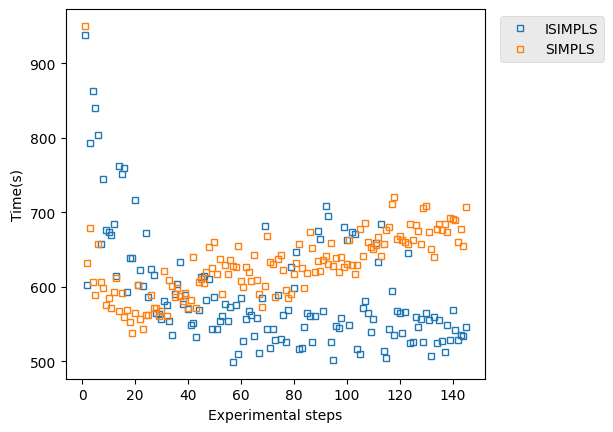

In [8]:
import matplotlib.pyplot as plt

N_steps= len(ISIMPLS['timer'][0])
fig, ax = plt.subplots()
plt.subplots_adjust(right=.65)
plt.style.use('ggplot')
ms = 4

plt.subplots_adjust(right=.78)

plt.plot(range(1,N_steps+1), ISIMPLS['timer'][1],
                label='ISIMPLS', ls='', marker='s', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), SIMPLS['timer'][1],
                label='SIMPLS', ls='', marker='s', markersize=ms, fillstyle='none')

ax.set_xlabel("Experimental steps")
ax.set_ylabel("Time(s)")
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.savefig('./fig/merra2_inc.pdf')
